# Pipeline accident cost prediction

In [4]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [5]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib as plt

# handle error messages
import warnings
warnings.filterwarnings("ignore")

## Data

In [6]:
path = './database.csv'
df = pd.read_csv(path,delimiter=',')
print(df.shape)
print(df.info())

(2795, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
Report Number                           2795 non-null int64
Supplemental Number                     2795 non-null int64
Accident Year                           2795 non-null int64
Accident Date/Time                      2795 non-null object
Operator ID                             2795 non-null int64
Operator Name                           2795 non-null object
Pipeline/Facility Name                  2674 non-null object
Pipeline Location                       2795 non-null object
Pipeline Type                           2777 non-null object
Liquid Type                             2795 non-null object
Liquid Subtype                          1349 non-null object
Liquid Name                             222 non-null object
Accident City                           2480 non-null object
Accident County                         2720 non-null object
Accident State                   

In [7]:
# Remove columns whose data is more than 90% NaNs
mask = df.apply(lambda x: x.isna().sum()/len(x) < 0.9)
mask = [mask[c] for c in range(len(mask))]
df_reduced = df.loc[:, mask]

# Number of columns reduced from 48 to 35
print(df_reduced.shape)
df_reduced.T

(2795, 35)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Report Number,20100016,20100254,20100038,20100260,20100030,20100021,20110036,20100255,20100261,20100024,...,20170020,20170022,20170021,20170023,20170026,20170015,20170028,20170027,20170024,20170025
Supplemental Number,17305,17331,17747,18574,16276,17161,18052,18584,18050,18390,...,22026,22029,22027,22030,22044,22020,22046,22045,22032,22040
Accident Year,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017
Accident Date/Time,1/1/2010 7:15 AM,1/4/2010 8:30 AM,1/5/2010 10:30 AM,1/6/2010 7:30 PM,1/7/2010 1:00 PM,1/8/2010 11:38 PM,1/9/2010 12:15 AM,1/9/2010 1:12 AM,1/10/2010 7:46 PM,1/11/2010 2:30 PM,...,12/21/2016 11:40 AM,12/22/2016 9:25 PM,12/23/2016 3:00 PM,12/24/2016 9:35 AM,12/26/2016 7:20 AM,12/27/2016 8:40 AM,12/28/2016 4:20 PM,12/29/2016 6:40 AM,1/3/2017 10:00 AM,1/9/2017 7:40 AM
Operator ID,32109,15786,20160,11169,300,11169,26041,12624,26041,31684,...,32147,32080,30829,31684,32011,32334,4906,39145,32147,30829
Operator Name,ONEOK NGL PIPELINE LP,PORTLAND PIPELINE CORP,"PETROLOGISTICS OLEFINS, LLC","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","PLAINS PIPELINE, L.P.","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","KINDER MORGAN LIQUID TERMINALS, LLC",MOBIL CORP,"KINDER MORGAN LIQUID TERMINALS, LLC",CONOCOPHILLIPS,...,MARATHON PIPE LINE LLC,"CCPS TRANSPORTATION, LLC",ENTERPRISE CRUDE PIPELINE LLC,PHILLIPS 66 PIPELINE LLC,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",TC OIL PIPELINE OPERATIONS INC,EXXONMOBIL PIPELINE CO,ENBRIDGE STORAGE (CUSHING) L.L.C.,MARATHON PIPE LINE LLC,ENTERPRISE CRUDE PIPELINE LLC
Pipeline/Facility Name,KINDER MORGAN JCT,24-INCH MAIN LINE,NaN,SUPERIOR TERMINAL,RED RIVER EAST,NaN,NaN,HULL STATION,NaN,TANK 1501,...,ELWOOD STATION,LINE 59 KEY STATION,ECHO MANIFOLD,"NT-90, PREDO TO CARSON",RUSSELL STATION,KEYSTONE,BRRF - CHOCTAW ETHANE/PROPANE MIX SYSTEM,CUSHING CENTRAL TERMINAL,MIDLAND STATION,MARSHALL STATION
Pipeline Location,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,...,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE
Pipeline Type,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,UNDERGROUND,UNDERGROUND,TANK,ABOVEGROUND,ABOVEGROUND,TANK,...,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,TANK,UNDERGROUND,ABOVEGROUND
Liquid Type,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,CRUDE OIL,CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",...,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",CRUDE OIL


'Shutdown duration' column creation

In [8]:
# Shutdown duration column creation
# Problem : only 1341 values
df_reduced['Shutdown Duration'] = (pd.to_datetime(df_reduced['Restart Date/Time']) - pd.to_datetime(df_reduced['Shutdown Date/Time']))\
.astype('timedelta64[h]')
df = df_reduced.fillna({'Shutdown Duration': 0}) # change nans into 0

# Statistics of Shutdown Duration
print(df['Shutdown Duration'].describe()) # hours

count     2795.000000
mean        90.337746
std        626.831444
min          0.000000
25%          0.000000
50%          0.000000
75%         18.000000
max      16746.000000
Name: Shutdown Duration, dtype: float64


In [9]:
'''
Notice: Net loss (Barrels) discloses some non-integer figures (0,89 ; 4,16 ; ...)
        Shutdown Duration has 1341 values only
'''
print(df.shape)
df.T

(2795, 36)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Report Number,20100016,20100254,20100038,20100260,20100030,20100021,20110036,20100255,20100261,20100024,...,20170020,20170022,20170021,20170023,20170026,20170015,20170028,20170027,20170024,20170025
Supplemental Number,17305,17331,17747,18574,16276,17161,18052,18584,18050,18390,...,22026,22029,22027,22030,22044,22020,22046,22045,22032,22040
Accident Year,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017
Accident Date/Time,1/1/2010 7:15 AM,1/4/2010 8:30 AM,1/5/2010 10:30 AM,1/6/2010 7:30 PM,1/7/2010 1:00 PM,1/8/2010 11:38 PM,1/9/2010 12:15 AM,1/9/2010 1:12 AM,1/10/2010 7:46 PM,1/11/2010 2:30 PM,...,12/21/2016 11:40 AM,12/22/2016 9:25 PM,12/23/2016 3:00 PM,12/24/2016 9:35 AM,12/26/2016 7:20 AM,12/27/2016 8:40 AM,12/28/2016 4:20 PM,12/29/2016 6:40 AM,1/3/2017 10:00 AM,1/9/2017 7:40 AM
Operator ID,32109,15786,20160,11169,300,11169,26041,12624,26041,31684,...,32147,32080,30829,31684,32011,32334,4906,39145,32147,30829
Operator Name,ONEOK NGL PIPELINE LP,PORTLAND PIPELINE CORP,"PETROLOGISTICS OLEFINS, LLC","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","PLAINS PIPELINE, L.P.","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","KINDER MORGAN LIQUID TERMINALS, LLC",MOBIL CORP,"KINDER MORGAN LIQUID TERMINALS, LLC",CONOCOPHILLIPS,...,MARATHON PIPE LINE LLC,"CCPS TRANSPORTATION, LLC",ENTERPRISE CRUDE PIPELINE LLC,PHILLIPS 66 PIPELINE LLC,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",TC OIL PIPELINE OPERATIONS INC,EXXONMOBIL PIPELINE CO,ENBRIDGE STORAGE (CUSHING) L.L.C.,MARATHON PIPE LINE LLC,ENTERPRISE CRUDE PIPELINE LLC
Pipeline/Facility Name,KINDER MORGAN JCT,24-INCH MAIN LINE,NaN,SUPERIOR TERMINAL,RED RIVER EAST,NaN,NaN,HULL STATION,NaN,TANK 1501,...,ELWOOD STATION,LINE 59 KEY STATION,ECHO MANIFOLD,"NT-90, PREDO TO CARSON",RUSSELL STATION,KEYSTONE,BRRF - CHOCTAW ETHANE/PROPANE MIX SYSTEM,CUSHING CENTRAL TERMINAL,MIDLAND STATION,MARSHALL STATION
Pipeline Location,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,...,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE
Pipeline Type,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,UNDERGROUND,UNDERGROUND,TANK,ABOVEGROUND,ABOVEGROUND,TANK,...,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,TANK,UNDERGROUND,ABOVEGROUND
Liquid Type,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,CRUDE OIL,CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",...,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",CRUDE OIL


### Data visualization

In [10]:
# Top 10 accidents by the amount of All Costs
print(df['All Costs'].sort_values(ascending=False).head(10))

# Statistics of All Costs
print(df['All Costs'].describe())

194     840526118
2103    142931884
523     135000000
1173     91300000
2675     66234072
241      47393566
457      35728903
160      32233740
133      28938000
1833     24323483
Name: All Costs, dtype: int64
count    2.795000e+03
mean     8.340332e+05
std      1.657830e+07
min      0.000000e+00
25%      5.039500e+03
50%      2.312900e+04
75%      1.172325e+05
max      8.405261e+08
Name: All Costs, dtype: float64


In [11]:
print(pd.crosstab(df['Liquid Ignition'], df['Liquid Explosion']))

Liquid Explosion    NO  YES
Liquid Ignition            
NO                2700    0
YES                 80   15


In [12]:
print("Number of distinct Operator ID:", len(df['Operator ID'].unique()))
print("Number of distinct Operator Name:", len(df['Operator Name'].unique()))

Number of distinct Operator ID: 213
Number of distinct Operator Name: 229


In [13]:
df['Cause Category'].value_counts(), df['Cause Category'].describe()

(MATERIAL/WELD/EQUIP FAILURE    1435
 CORROSION                       592
 INCORRECT OPERATION             378
 NATURAL FORCE DAMAGE            118
 ALL OTHER CAUSES                118
 EXCAVATION DAMAGE                97
 OTHER OUTSIDE FORCE DAMAGE       57
 Name: Cause Category, dtype: int64, count                            2795
 unique                              7
 top       MATERIAL/WELD/EQUIP FAILURE
 freq                             1435
 Name: Cause Category, dtype: object)

In [14]:
df["Pipeline Type"].value_counts(), df['Pipeline Type'].describe()

(ABOVEGROUND        1475
 UNDERGROUND         985
 TANK                301
 TRANSITION AREA      16
 Name: Pipeline Type, dtype: int64, count            2777
 unique              4
 top       ABOVEGROUND
 freq             1475
 Name: Pipeline Type, dtype: object)

In [15]:
df["Liquid Type"].value_counts(), df["Liquid Type"].describe()

(CRUDE OIL                                               1398
 REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID       939
 HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS               418
 CO2 (CARBON DIOXIDE)                                      38
 BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)       2
 Name: Liquid Type, dtype: int64, count          2795
 unique            5
 top       CRUDE OIL
 freq           1398
 Name: Liquid Type, dtype: object)

In [16]:
print(df.groupby(['Accident Year'])['All Costs'].mean())
print(df.groupby(['Accident Year'])['All Costs'].count())

Accident Year
2010    3.071983e+06
2011    7.928306e+05
2012    3.968509e+05
2013    6.945774e+05
2014    2.900540e+05
2015    5.491256e+05
2016    4.172569e+05
2017    4.361400e+04
Name: All Costs, dtype: float64
Accident Year
2010    350
2011    345
2012    366
2013    401
2014    454
2015    462
2016    415
2017      2
Name: All Costs, dtype: int64


In [18]:
print(df.groupby(['Liquid Ignition'])['All Costs'].mean())
print(df.groupby(['Liquid Explosion'])['All Costs'].mean())
print(df.groupby(['Liquid Ignition'])['All Costs'].max())
print(df.groupby(['Liquid Explosion'])['All Costs'].max())

Liquid Ignition
NO     842947.114444
YES    580691.726316
Name: All Costs, dtype: float64
Liquid Explosion
NO     8.324311e+05
YES    1.130972e+06
Name: All Costs, dtype: float64
Liquid Ignition
NO     840526118
YES     10262149
Name: All Costs, dtype: int64
Liquid Explosion
NO     840526118
YES      6910591
Name: All Costs, dtype: int64


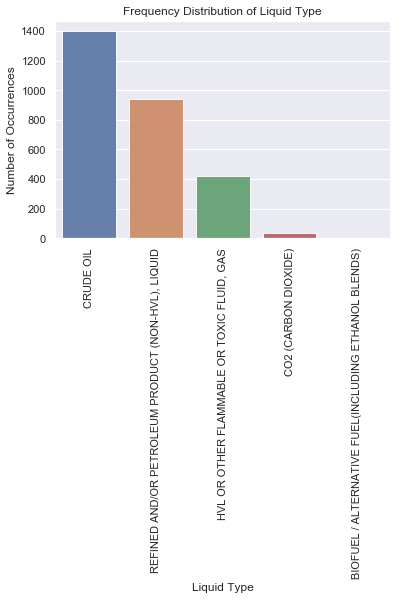

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
Liquid_Type_count = df['Liquid Type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(Liquid_Type_count.index, Liquid_Type_count.values, alpha=0.9, errwidth=0.1)
plt.title('Frequency Distribution of Liquid Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Liquid Type', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Pipeline Type')

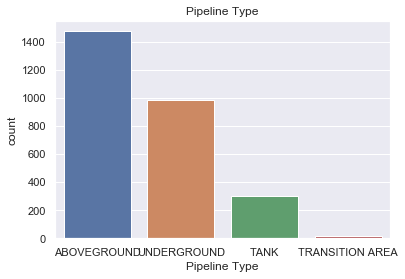

In [20]:
sns.countplot(df['Pipeline Type'])
plt.title('Pipeline Type')

Text(0.5, 1.0, 'Total costs per Pipeline Type')

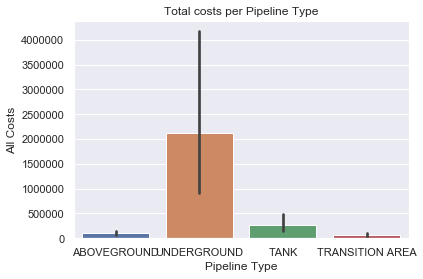

In [21]:
df_PipeLine_Type_All_Cost = df[['Pipeline Type','All Costs']]
sns.barplot(x='Pipeline Type', y="All Costs",  data=df_PipeLine_Type_All_Cost)
plt.title('Total costs per Pipeline Type')

Text(0.5, 1.0, '# Net Loss (Barrels)')

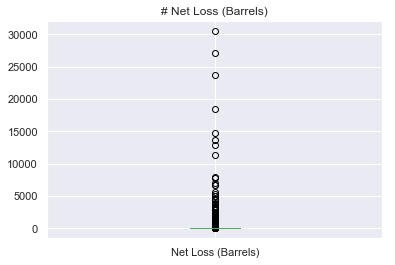

In [22]:
df.boxplot(column='Net Loss (Barrels)')
plt.title('# Net Loss (Barrels)')

### Outliers identification and costs structure plots

(2795, 36)


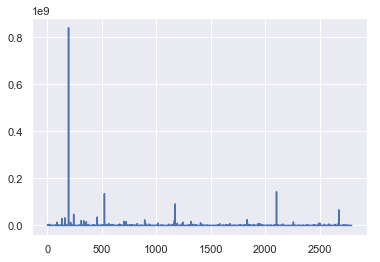

In [23]:
df['All Costs'].plot()
print(df.shape)

Text(0.5, 0, 'Index')

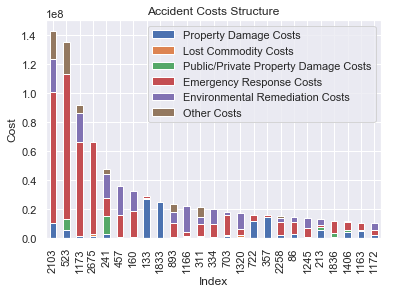

In [25]:
b = df['All Costs'].sort_values(ascending=False) [:30]
top25 = df.iloc[b.index[1:26], 28:-2]
top25.plot.bar(stacked=True)
plt.title('Accident Costs Structure')
plt.ylabel('Cost', fontsize=12)
plt.xlabel('Index', fontsize=12)

In [26]:
print('Property Damage Costs:                ', "{:,}".format(df['Property Damage Costs'].sum()))
print('Environmental Remediation Costs:      ', "{:,}".format(df['Environmental Remediation Costs'].sum()))
print('Emergency Response Costs:             ', "{:,}".format(df['Emergency Response Costs'].sum()))
print('Lost Commodity Costs:                 ', "{:,}".format(df['Lost Commodity Costs'].sum()))
print('Public/Private Property Damage Costs: ', "{:,}".format(df['Public/Private Property Damage Costs'].sum()))
print('All Costs:                            ', "{:,}".format(df['All Costs'].sum()))

Property Damage Costs:                 313,081,992.0
Environmental Remediation Costs:       1,011,149,910.0
Emergency Response Costs:              814,084,371.0
Lost Commodity Costs:                  27,366,589.0
Public/Private Property Damage Costs:  69,964,627.0
All Costs:                             2,331,122,923


## New dataset for machine learning and correlation matrix

### Column selection

In [111]:
# Select columns to be used for prediction
s = pd.Series([34,2,4,7,8,9,13,14,15,16,22,23,27,21,35])

# Highlight the selected columns
for col in range(len(df.columns)):
    if col in list(s):
        print("\033[31m" + str(col), df.columns[col] + "\033[0m")
    else:
        print(col, df.columns[col])

0 Report Number
1 Supplemental Number
2 Accident Year
3 Accident Date/Time
4 Operator ID
5 Operator Name
6 Pipeline/Facility Name
7 Pipeline Location
8 Pipeline Type
9 Liquid Type
10 Liquid Subtype
11 Accident City
12 Accident County
13 Accident State
14 Accident Latitude
15 Accident Longitude
16 Cause Category
17 Cause Subcategory
18 Unintentional Release (Barrels)
19 Intentional Release (Barrels)
20 Liquid Recovery (Barrels)
21 Net Loss (Barrels)
22 Liquid Ignition
23 Liquid Explosion
24 Pipeline Shutdown
25 Shutdown Date/Time
26 Restart Date/Time
27 Public Evacuations
28 Property Damage Costs
29 Lost Commodity Costs
30 Public/Private Property Damage Costs
31 Emergency Response Costs
32 Environmental Remediation Costs
33 Other Costs
34 All Costs
35 Shutdown Duration


In [112]:
df_selected = df[df.columns[s[:,]]].copy()
print(df_selected.shape)

(2795, 15)


In [113]:
# There are 18 NaNs in Pipeline Type column
print('pipeline type nans: ', df_selected["Pipeline Type"].isna().sum())

# Delete those 18 rows
df_selected2 = df_selected[df_selected["Pipeline Type"].isna() == False]
print(df_selected2.shape)

pipeline type nans:  18
(2777, 15)


count    2777.000000
mean        9.998329
std         2.616485
min         0.000000
25%         8.524963
50%        10.043249
75%        11.644392
max        20.549539
Name: Log All Costs, dtype: float64


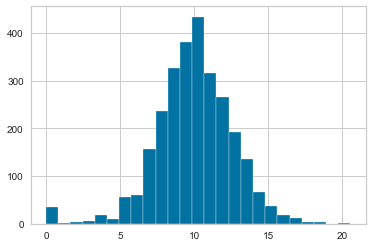

In [114]:
# Take logarithm of All Cost to avoid scaling problem
LogAllCost = np.log(df_selected2['All Costs'])
LogAllCost = LogAllCost.replace([np.inf, -np.inf], np.nan).fillna(0)  # Replace -inf with 0
df_selected2['Log All Costs'] = LogAllCost

print(df_selected2['Log All Costs'].describe())
df_selected2['Log All Costs'].hist(bins=25)

In [115]:
print(df_selected2.shape)
df_selected2.head()

(2777, 16)


,All Costs,Accident Year,Operator ID,Pipeline Location,Pipeline Type,Liquid Type,Accident State,Accident Latitude,Accident Longitude,Cause Category,Liquid Ignition,Liquid Explosion,Public Evacuations,Net Loss (Barrels),Shutdown Duration,Log All Costs
0,1627,2010,32109,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",KS,38.67070,-97.78123,INCORRECT OPERATION,NO,NO,NaN,21.0,0.0,7.394493
1,4008,2010,15786,ONSHORE,ABOVEGROUND,CRUDE OIL,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,NO,NO,NaN,0.0,0.0,8.296048
2,200,2010,20160,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,NO,NO,NaN,2.0,0.0,5.298317
3,11540,2010,11169,ONSHORE,UNDERGROUND,CRUDE OIL,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,NO,NO,NaN,0.0,0.0,9.353575
4,29650,2010,300,ONSHORE,UNDERGROUND,CRUDE OIL,TX,33.58266,-96.64881,EXCAVATION DAMAGE,NO,NO,NaN,2.0,0.0,10.297217


In [116]:
df_selected2.cov() # Covariance matrix is not easily readable

,All Costs,Accident Year,Operator ID,Accident Latitude,Accident Longitude,Public Evacuations,Net Loss (Barrels),Shutdown Duration,Log All Costs
All Costs,2.766177e+14,-1.149338e+06,-6.210625e+09,3.334318e+06,1.334834e+06,3.885820e+07,1.224263e+09,6.695324e+08,6.502681e+06
Accident Year,-1.149338e+06,3.887583e+00,2.327874e+03,-5.592019e-01,-5.631736e-01,-1.385844e+00,-1.650127e+01,-2.294648e+01,-6.190332e-02
Operator ID,-6.210625e+09,2.327874e+03,1.541964e+08,-5.684577e+03,-2.160435e+04,-1.012876e+04,5.866745e+05,1.708991e+04,-2.784645e+03
Accident Latitude,3.334318e+06,-5.592019e-01,-5.684577e+03,3.183416e+01,-5.231600e-01,7.132862e-01,-1.741015e+01,-8.094807e+01,1.099706e+00
Accident Longitude,1.334834e+06,-5.631736e-01,-2.160435e+04,-5.231600e-01,1.528029e+02,3.897194e+00,2.160553e+02,7.613457e+01,7.784807e-01
Public Evacuations,3.885820e+07,-1.385844e+00,-1.012876e+04,7.132862e-01,3.897194e+00,3.320233e+02,2.111851e+03,2.301345e+02,5.179515e+00
Net Loss (Barrels),1.224263e+09,-1.650127e+01,5.866745e+05,-1.741015e+01,2.160553e+02,2.111851e+03,1.413267e+06,4.991452e+04,4.911096e+02
Shutdown Duration,6.695324e+08,-2.294648e+01,1.708991e+04,-8.094807e+01,7.613457e+01,2.301345e+02,4.991452e+04,3.944884e+05,2.580605e+02
Log All Costs,6.502681e+06,-6.190332e-02,-2.784645e+03,1.099706e+00,7.784807e-01,5.179515e+00,4.911096e+02,2.580605e+02,6.845993e+00


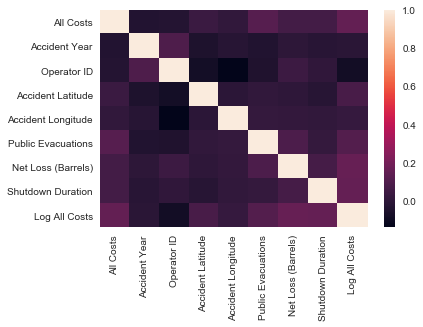

In [117]:
corr = df_selected2.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [118]:
newdf = df_selected2.copy()

### One-hot encoding & Value replacement

In [119]:
# Extract names of the categorical columns
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2777 entries, 0 to 2794
Data columns (total 16 columns):
All Costs             2777 non-null int64
Accident Year         2777 non-null int64
Operator ID           2777 non-null int64
Pipeline Location     2777 non-null object
Pipeline Type         2777 non-null object
Liquid Type           2777 non-null object
Accident State        2777 non-null object
Accident Latitude     2777 non-null float64
Accident Longitude    2777 non-null float64
Cause Category        2777 non-null object
Liquid Ignition       2777 non-null object
Liquid Explosion      2777 non-null object
Public Evacuations    2320 non-null float64
Net Loss (Barrels)    2777 non-null float64
Shutdown Duration     2777 non-null float64
Log All Costs         2777 non-null float64
dtypes: float64(6), int64(3), object(7)
memory usage: 368.8+ KB


In [120]:
categorical_columns = [col for col in newdf.columns if newdf[col].dtype == 'object']
# Add Operator ID column manually
categorical_columns.append('Operator ID')
categorical_columns

['Pipeline Location',
 'Pipeline Type',
 'Liquid Type',
 'Accident State',
 'Cause Category',
 'Liquid Ignition',
 'Liquid Explosion',
 'Operator ID']

In [121]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

# Loop for one-hot encoding
for col in categorical_columns:
    dum = pd.get_dummies(newdf[col], prefix=col, drop_first=True)
    newdf = pd.concat([newdf, dum], axis=1)
    newdf = newdf.drop([col], axis=1)

print(newdf.shape)
newdf.T

(2777, 278)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
All Costs,1627.000000,4008.000000,200.000000,11540.000000,29650.000000,4.194715e+06,70400.000000,413.000000,40336.0000,30050.000000,...,66041.000000,47047.000000,65075.000000,258510.000000,13120.000000,61015.000000,105400.000000,15050.000000,41428.000000,45800.000000
Accident Year,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2.010000e+03,2010.000000,2010.000000,2010.0000,2010.000000,...,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
Accident Latitude,38.670700,43.940280,30.182400,46.689300,33.582660,4.899555e+01,29.430500,30.085330,29.4305,29.714780,...,40.291648,39.414038,29.614125,33.655692,32.861800,39.517036,30.332597,35.565292,40.631074,29.305410
Accident Longitude,-97.781230,-70.493360,-93.352400,-92.061200,-96.648810,-9.752554e+01,-95.120100,-94.380500,-95.1201,-95.176110,...,-85.862792,-92.840164,-95.184793,-98.624766,-102.919210,-93.486055,-91.274491,-96.454956,-80.440463,-97.400301
Public Evacuations,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Loss (Barrels),21.000000,0.000000,2.000000,0.000000,2.000000,2.237000e+03,5.000000,0.240000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,580.000000,0.000000,0.000000,0.000000
Shutdown Duration,0.000000,0.000000,0.000000,0.000000,0.000000,1.050000e+02,0.000000,0.000000,0.0000,0.000000,...,18.000000,4.000000,0.000000,0.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000
Log All Costs,7.394493,8.296048,5.298317,9.353575,10.297217,1.524934e+01,11.161949,6.023448,10.6050,10.310618,...,11.098031,10.758902,11.083296,12.462690,9.481893,11.018875,11.565518,9.619133,10.631712,10.732039
Pipeline Type_TANK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.0000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Pipeline Type_TRANSITION AREA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [122]:
df_scaled = df_selected2

# Make indexes for each column that we want to transform by scaling method
indexes_p = df_scaled.groupby(['Pipeline Type'])['All Costs'].mean().index
indexes_P = df_scaled.groupby(['Pipeline Type'])['All Costs'].mean().index

# Make a list of mean costs for each category
mean_cost_for_each_category_p = \
[df_scaled.groupby(['Pipeline Type'])['All Costs'].mean()[index] for index in indexes]

# Make a dictionary for replacement
dic_mean_cost_for_each_category_p = {}
for i in range(len(indexes)):
    dic_mean_cost_for_each_category_p[indexes[i]] = mean_cost_for_each_category_p[i]
    
dic_mean_cost_for_each_category_p

{'ABOVEGROUND': 104089.86644067797,
 'TANK': 270372.82724252495,
 'TRANSITION AREA': 63422.6875,
 'UNDERGROUND': 2112992.0487309643}

In [123]:
# Create a new column for scaled version of the column
df_scaled['Pipeline Type_Scaled'] = df_scaled['Pipeline Type'].replace(dic_mean_cost_for_each_category_p)
df_scaled.head()

,All Costs,Accident Year,Operator ID,Pipeline Location,Pipeline Type,Liquid Type,Accident State,Accident Latitude,Accident Longitude,Cause Category,Liquid Ignition,Liquid Explosion,Public Evacuations,Net Loss (Barrels),Shutdown Duration,Log All Costs,Pipeline Type_Scaled
0,1627,2010,32109,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",KS,38.67070,-97.78123,INCORRECT OPERATION,NO,NO,NaN,21.0,0.0,7.394493,1.040899e+05
1,4008,2010,15786,ONSHORE,ABOVEGROUND,CRUDE OIL,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,NO,NO,NaN,0.0,0.0,8.296048,1.040899e+05
2,200,2010,20160,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,NO,NO,NaN,2.0,0.0,5.298317,1.040899e+05
3,11540,2010,11169,ONSHORE,UNDERGROUND,CRUDE OIL,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,NO,NO,NaN,0.0,0.0,9.353575,2.112992e+06
4,29650,2010,300,ONSHORE,UNDERGROUND,CRUDE OIL,TX,33.58266,-96.64881,EXCAVATION DAMAGE,NO,NO,NaN,2.0,0.0,10.297217,2.112992e+06


## Modelling and regression

Model Selection Reference: https://scikit-learn.org/stable/model_selection.html

PCA trial: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

In [124]:
# Small PCA trial for feature selection
import numpy as np
from sklearn.decomposition import IncrementalPCA
X_ = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(X_)
IncrementalPCA(batch_size=3, copy=True, n_components=2, whiten=False)
ipca.transform(X_)

array([[-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385],
       [ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385]])

In [125]:
%matplotlib inline
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
import math
import sklearn.metrics as metrics

In [147]:
cols = dataframe.columns.tolist()
cols

['All Costs',
 'Accident Year',
 'Accident Latitude',
 'Accident Longitude',
 'Public Evacuations',
 'Net Loss (Barrels)',
 'Shutdown Duration',
 'Log All Costs',
 'Pipeline Type_TANK',
 'Pipeline Type_TRANSITION AREA',
 'Pipeline Type_UNDERGROUND',
 'Liquid Type_CO2 (CARBON DIOXIDE)',
 'Liquid Type_CRUDE OIL',
 'Liquid Type_HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS',
 'Liquid Type_REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID',
 'Accident State_AL',
 'Accident State_AR',
 'Accident State_CA',
 'Accident State_CO',
 'Accident State_CT',
 'Accident State_FL',
 'Accident State_GA',
 'Accident State_HI',
 'Accident State_IA',
 'Accident State_ID',
 'Accident State_IL',
 'Accident State_IN',
 'Accident State_KS',
 'Accident State_KY',
 'Accident State_LA',
 'Accident State_MA',
 'Accident State_MD',
 'Accident State_ME',
 'Accident State_MI',
 'Accident State_MN',
 'Accident State_MO',
 'Accident State_MS',
 'Accident State_MT',
 'Accident State_NC',
 'Accident State_ND',
 'Accident 

In [153]:
dataframe = newdf.dropna(axis=0).copy()
# Extract the X and y data from the dataframe
l = len(dataframe.columns)
X = dataframe.drop(['All Costs', 'Log All Costs'], axis=1)
#X = dataframe.iloc[:,1:(l-1)]

print("Shape of X:", X.shape)
y = dataframe['Log All Costs']

# Create the train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # seems to be the sample optimal test size

Shape of X: (2320, 276)


### Linear Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [154]:
model0 = LinearRegression()
model0.fit(X_train, y_train)

print("TRAINING SET")
print("R-Squared:", model0.score(X_train, y_train))
print("\nTEST SET")
print("R-Squared:", model0.score(X_test, y_test))

TRAINING SET
R-Squared: 0.43035067377959335

TEST SET
R-Squared: -1275948641937651.0


### Ridge
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

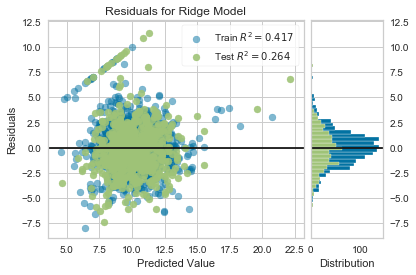

In [155]:
# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()             # Draw/show/poof the data

As a reminder, R² formula:
$$ R^2 = 1 - \frac{Sum of Squares of Residuals}{Total Sum of Squares} = 1 - \frac{\sum_i ( y_i - f_i )^2}{\sum_i (y_i - \bar{y})^2}$$

### K-Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [156]:
# Model creation and fit
model1 = BaggingRegressor(KNeighborsRegressor(n_neighbors=3))
model1.fit(X_train,y_train)

# Show model results of training set
y2_hat = model1.predict(X_train)
mae = metrics.mean_absolute_error(y_train,y2_hat)
mse = metrics.mean_squared_error(y_train,y2_hat)
print ("TRAINING SET")
print ("=========================================")
print ("MAE:         ", mae)
print ("MSE:         ", math.sqrt(mse))
print ("r2:          ", model1.score(X_train,y_train))
print ("n_features:  ", model1.n_features_)

# Show model results of test set
y_hat_test = model1.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat_test)
mse = metrics.mean_squared_error(y_test,y_hat_test)
print ("\nTEST SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", model1.score(X_test,y_test))
print ("r2 retry:           ", r2_score(y_test, y_hat_test))
print ("n_features:         ", model1.n_features_)

TRAINING SET
MAE:          1.1741679595459624
MSE:          1.6209055736342497
r2:           0.6140283508496456
n_features:   276

TEST SET
MAE:                 1.902697966890721
RMSE:                2.61853720082367
r2:                  0.16381937678710656
r2 retry:            0.16381937678710656
n_features:          276


### AdaBoost

In [157]:
# AdaBoost
model2 = AdaBoostRegressor(n_estimators=50)
scores = cross_val_score(model2, X, y, cv=5) # Cross-Validation
scores.mean() 

0.22524361235082324

### Random Forest Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [158]:
# Model creation and fit
model3 = RandomForestRegressor(max_depth=3)
model3.fit(X_train,y_train)

# Show model results of training set
y2_hat = model3.predict(X_train)
mae = metrics.mean_absolute_error(y_train,y2_hat)
mse = metrics.mean_squared_error(y_train,y2_hat)
print ("TRAINING SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("MSE:                ", math.sqrt(mse))
print ("r2:                 ", model3.score(X_train,y_train))
print ("n_features:         ", model3.n_features_)
print ("n_outputs:          ", model3.n_outputs_)

# Show model results of test set
y_hat_test = model3.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat_test)
mse = metrics.mean_squared_error(y_test,y_hat_test)
print ("\nTEST SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", model3.score(X_test,y_test))
print ("r2 retry:           ", r2_score(y_test, y_hat_test))
print ("n_features:         ", model3.n_features_)
print ("n_outputs:          ", model3.n_outputs_)

TRAINING SET
MAE:                 1.555131815285206
MSE:                 2.0972005673017127
r2:                  0.3538699979226241
n_features:          276
n_outputs:           1

TEST SET
MAE:                 1.7311598348767785
RMSE:                2.463415554375194
r2:                  0.25995528466788564
r2 retry:            0.25995528466788564
n_features:          276
n_outputs:           1


## Conclusion